In [156]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Masking, Bidirectional, Dropout, TimeDistributed
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras_contrib.layers import CRF
from keras_contrib.utils import save_load_utils
from keras.callbacks import CSVLogger
from gensim.models import KeyedVectors
import tensorflow as tf
import numpy as np
import keras as ks
import matplotlib.pyplot as plt

In [5]:
train_path = 'data/msra/msra_train.txt'
cv_path = 'data/msra/msra_testright.txt'
test_path = 'data/msra/msra_testright.txt'
wv_path = 'word2vec_model/news12g_bdbk20g_nov90g_dim128.bin'
MAX_TEXT_LENGTH = 581

In [285]:
def read_data(path):
    with open(path, encoding='utf-8') as f:
        sentences = []
        sentences_ner = []
        pos = []
        sentence = ''
        l = f.readlines()
        for index, line in enumerate(l):
            line = line.strip()
            if len(line):
                word, p = line.split()
                sentence += word
                pos.append(p)
            else:
                sentences.append(sentence)
                sentences_ner.append(pos)
                sentence = ''
                pos = []
        return sentences, sentences_ner


def read_and_fit(path, word_tokenizer, pos_tokenizer):
    sentences, pos = read_data(path)
    word_tokenizer.fit_on_texts(sentences)
    pos_tokenizer.fit_on_texts(pos)
    return sentences, pos, word_tokenizer, pos_tokenizer


def prepare_x(sentences, tokenizer):
    seqs = tokenizer.texts_to_sequences(sentences)
    seqs = pad_sequences(seqs, maxlen=MAX_TEXT_LENGTH)
    return seqs


def prepare_y(pos, tokenizer):
    seqs = tokenizer.texts_to_sequences(pos)
    pad = tokenizer.word_index['O']
    seqs = pad_sequences(seqs, value=pad, maxlen=MAX_TEXT_LENGTH)
    seqs = np.vectorize(lambda x: x - 1)(seqs)  # decrease 1 on every element
    y = to_categorical(seqs)
    return y


def prepare_data(sentences, pos, word_tokenizer, pos_tokenizer):
    return prepare_x(sentences, word_tokenizer), prepare_y(pos, pos_tokenizer)


def preprocessing(train_path, cv_path=None, test_path=None):
    word_tokenizer = Tokenizer(char_level=True)
    pos_tokenizer = Tokenizer()

    print('Reading train data...')
    train_sens, train_pos, word_tokenizer, pos_tokenizer = read_and_fit(
        train_path, word_tokenizer, pos_tokenizer)
    if cv_path:
        print('Reading cv data...')
        cv_sens, cv_pos, word_tokenizer, pos_tokenizer = read_and_fit(
            cv_path, word_tokenizer, pos_tokenizer)
    if test_path:
        print('Reading test data...')
        test_sens, test_pos, word_tokenizer, pos_tokenizer = read_and_fit(
            test_path, word_tokenizer, pos_tokenizer)

    print('Preparing train data...')
    x_train, y_train = prepare_data(train_sens, train_pos, word_tokenizer,
                                    pos_tokenizer)
    if cv_path:
        print('Preparing cv data...')
        x_cv, y_cv = prepare_data(cv_sens, cv_pos, word_tokenizer,
                                  pos_tokenizer)
    if test_path:
        print('Preparing test data...')
        x_test, y_test = prepare_data(test_sens, test_pos, word_tokenizer,
                                      pos_tokenizer)

    return (x_train, y_train, x_cv, y_cv, x_test, y_test, word_tokenizer,
            pos_tokenizer)


def make_embedding_matrix(wv, word_index):
    embedding_matrix = np.zeros((len(word_index) + 1, 64))
    for word, i in word_index.items():
        if word in wv.vocab:
            embedding_matrix[i] = wv.word_vec(word)
    return embedding_matrix


def load_and_make_embedding_matrix(wv_path, word_index):
    wv = KeyedVectors.load_word2vec_format(
        'word2vec_model/news12g_bdbk20g_nov90g_dim128.bin', binary=True)
    embedding_matrix = make_embedding_matrix(wv, word_index)
    return embedding_matrix, wv


def recall(y_true, y_pred):
    y_t = np.argmax(y_true, axis=2).ravel()
    y_p = np.argmax(y_pred, axis=2).ravel()
    postive = np.sum(np.logical_and(y_t > 0, y_t == y_p))
    tot = np.sum(y_t > 0)
    return postive / tot

def precision(y_true, y_pred):
    y_t = np.argmax(y_true, axis=2).ravel()
    y_p = np.argmax(y_pred, axis=2).ravel()
    postive = np.sum(np.logical_and(y_t > 0, y_t == y_p))
    tot = np.sum(y_p > 0)
    return postive / tot

def accuracy(y_true, y_pred):
    y_t = np.argmax(y_true, axis=2).ravel()
    y_p = np.argmax(y_pred, axis=2).ravel()
    return np.sum(y_t == y_p) / len(y_t)

def make_matrix(y_true, y_pred):
    y_t = np.argmax(y_true, axis=2).ravel()
    y_p = np.argmax(y_pred, axis=2).ravel()
    return pd.crosstab(y_t, y_p,rownames=['0','1','2','3','4','5','6'], colnames=['Predict'])
    

def eval(y_true, y_pred):
    rec = recall(y_true, y_pred)
    acc = accuracy(y_true, y_pred)
    pre = precision(y_true, y_pred)
    f1 = 2 * rec * pre / (rec + pre)
    print('precision:', pre,'recall:', rec, 'accuracy:', acc, 'f1:', f1)

def test_sentences(sentences):
    vec = word_tokenizer.texts_to_sequences([sentences])
    vec = pad_sequences(vec, MAX_TEXT_LENGTH)
    ret = model.predict([vec])[0][-len(sentences):]
    ret = np.argmax(ret, axis=1) + 1
    return [index_pos[x] for x in ret]


def pretty_ner(sentences, ner_ret):
    for x, y in zip(sentences, ner_ret):
        print(x, y)

def plot_confusiopdmatrix(df_confusion, title='Confusion matrix',
                          cmap=plt.cm.RdBu_r):
    df_confusion = df_confusion / df_confusion.sum(axis=1)
#     for i in range(7):
#         df_confusion[i][i]=0
    from pylab import rcParams
    rcParams['figure.figsize'] = 8, 6
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, ['O','BP','IP','BL','IL','BO','IO'], rotation=45)
    plt.yticks(tick_marks, ['O','BP','IP','BL','IL','BO','IO'])
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

import pickle
def save_obj(filename, obj):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)
        

def load_obj(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


In [37]:
(x_train, y_train, x_cv, y_cv, x_test, y_test, word_tokenizer,
 pos_tokenizer) = preprocessing(
     train_path=train_path,
     cv_path=cv_path,
     test_path=test_path)

Reading train data...
Reading cv data...
Reading test data...
Preparing train data...
Preparing cv data...
Preparing test data...


## Make embedding matrix
API Doc: [gensim.models.keyedvectors.Word2VecKeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.Word2VecKeyedVectors)

In [38]:
embedding_matrix, _ = load_and_make_embedding_matrix(
    wv_path=wv_path,
    word_index=word_tokenizer.word_index)

In [39]:
print(x_train.shape, y_train.shape)
print(x_cv.shape, y_cv.shape)
print(x_test.shape, y_test.shape)
print(embedding_matrix.shape)

(28145, 577) (28145, 577, 7)
(2399, 577) (2399, 577, 7)
(2399, 577) (2399, 577, 7)
(4529, 64)


In [308]:
model = Sequential()
model.add(
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=64,
        weights=[embedding_matrix],
        input_length=MAX_TEXT_LENGTH,
        trainable=False,
        mask_zero=True
        ))
model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.5)))
model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.5)))
model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.5)))
# model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dense(7))  
crf = CRF(7)
model.add(crf)
model.compile(
    optimizer=ks.optimizers.Adadelta(),
    loss=crf.loss_function,
    metrics=[crf.accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 577, 64)           289856    
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 577, 128)          66048     
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 577, 128)          98816     
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 577, 128)          98816     
_________________________________________________________________
dense_29 (Dense)             (None, 577, 7)            903       
_________________________________________________________________
crf_13 (CRF)                 (None, 577, 7)            119       
Total params: 554,558
Trainable params: 264,702
Non-trainable params: 289,856
________________________________________________________________

In [287]:
model = Sequential()
model.add(
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=64,
        weights=[embedding_matrix],
        input_length=MAX_TEXT_LENGTH,
        trainable=False,
        mask_zero=True
        ))
model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.5)))
model.add((Dense(7,activation='softmax')))
# crf = CRF(7)
# model.add(crf)
model.compile(
    optimizer=ks.optimizers.Adadelta(),
    loss=ks.losses.categorical_crossentropy,
    metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 577, 64)           289856    
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 577, 128)          66048     
_________________________________________________________________
dense_25 (Dense)             (None, 577, 7)            903       
Total params: 356,807
Trainable params: 66,951
Non-trainable params: 289,856
_________________________________________________________________


## Benchmark
|Model|Recall|
|-----|------|
|LSTM|52.58%|
|LSTM with masking|60.2%|
|BiLSTM with masking|68%|
|BiLSTM with masking+CRF|72%|
|BiLSTM with masking+CRF+Dropout0.3|82.21%| Training on 100 epochs
|BiLSTM with masking+CRF+Dropout0.5|83.29%| Training on 250 epochs

## Benchmark on test
|Model|Precision|Recall|Accuracy|F1
|-----|------|
|LSTM + CRF|86.989|79.221|99.645|82.924|
|BiLSTM with masking||||
|BiLSTM with masking+CRF|88.234|83.436|99.701|85.768|
|BiLSTM with masking+CRF+Dropout0.3|85.215|86.174|99.69|85.692|
|BiLSTM with masking+CRF+Dropout0.5|86.970|85.934|99.709|86.450|
|stacked BiLSTM + CRF|88.099|86.486|99.726|87.285|

## Benchmark on dev
|Model|Precision|Recall|Accuracy|F1
|-----|------|
|LSTM with masking + CRF|92.922|87.111|99.771|89.923|
|BiLSTM with masking||||
|BiLSTM with masking+CRF|99.075|97.358|99.957|98.209|
|BiLSTM with masking+CRF+Dropout0.3|96.409|97.519|99.929|96.961|
|BiLSTM with masking+CRF+Dropout0.5|97.183|96.997|99.934|97.090|
|stacked BiLSTM + CRF|99.126|98.907|99.977|99.016|

In [311]:
# csvlogger = CSVLogger('log/ner_bilstm_crf_dropout0.3.csv', append=True)
model.fit(x_train, y_train, epochs=250, batch_size=256)

Epoch 1/250
28145/28145 [==============================] - 745s 26ms/step - loss: 27.4555 - acc: 0.8340
Epoch 2/250
28145/28145 [==============================] - 732s 26ms/step - loss: 27.2456 - acc: 0.8601
Epoch 3/250
28145/28145 [==============================] - 730s 26ms/step - loss: 27.1469 - acc: 0.8930
Epoch 4/250
28145/28145 [==============================] - 729s 26ms/step - loss: 27.0887 - acc: 0.9121
Epoch 5/250
28145/28145 [==============================] - 726s 26ms/step - loss: 27.0519 - acc: 0.9227
Epoch 6/250
28145/28145 [==============================] - 728s 26ms/step - loss: 27.0260 - acc: 0.9303
Epoch 7/250
28145/28145 [==============================] - 726s 26ms/step - loss: 27.0075 - acc: 0.9352
Epoch 8/250
28145/28145 [==============================] - 727s 26ms/step - loss: 26.9916 - acc: 0.9404
Epoch 9/250
28145/28145 [==============================] - 726s 26ms/step - loss: 26.9811 - acc: 0.9430
Epoch 10/250
28145/28145 [==============================] - 728s

28145/28145 [==============================] - 730s 26ms/step - loss: 26.8848 - acc: 0.9814
Epoch 80/250
28145/28145 [==============================] - 729s 26ms/step - loss: 26.8843 - acc: 0.9819
Epoch 81/250
28145/28145 [==============================] - 730s 26ms/step - loss: 26.8846 - acc: 0.9811
Epoch 82/250
28145/28145 [==============================] - 731s 26ms/step - loss: 26.8839 - acc: 0.9822
Epoch 83/250
28145/28145 [==============================] - 730s 26ms/step - loss: 26.8837 - acc: 0.9820
Epoch 84/250
28145/28145 [==============================] - 732s 26ms/step - loss: 26.8840 - acc: 0.9816
Epoch 85/250
28145/28145 [==============================] - 731s 26ms/step - loss: 26.8832 - acc: 0.9826
Epoch 86/250
28145/28145 [==============================] - 733s 26ms/step - loss: 26.8832 - acc: 0.9823
Epoch 87/250
28145/28145 [==============================] - 733s 26ms/step - loss: 26.8827 - acc: 0.9830
Epoch 88/250
28145/28145 [==============================] - 730s 26m

28145/28145 [==============================] - 724s 26ms/step - loss: 26.8687 - acc: 0.9939
Epoch 234/250
28145/28145 [==============================] - 723s 26ms/step - loss: 26.8686 - acc: 0.9939
Epoch 235/250
28145/28145 [==============================] - 722s 26ms/step - loss: 26.8685 - acc: 0.9940
Epoch 236/250
28145/28145 [==============================] - 725s 26ms/step - loss: 26.8689 - acc: 0.9933
Epoch 237/250
28145/28145 [==============================] - 723s 26ms/step - loss: 26.8688 - acc: 0.9937
Epoch 238/250
28145/28145 [==============================] - 724s 26ms/step - loss: 26.8685 - acc: 0.9938
Epoch 239/250
28145/28145 [==============================] - 743s 26ms/step - loss: 26.8683 - acc: 0.9941
Epoch 240/250
28145/28145 [==============================] - 765s 27ms/step - loss: 26.8685 - acc: 0.9939
Epoch 241/250
28145/28145 [==============================] - 810s 29ms/step - loss: 26.8684 - acc: 0.9940
Epoch 242/250
28145/28145 [==============================] -

In [328]:
# set batch_size = 4096 will lead to OOM
y_train_hat = model.predict(x_train, batch_size=2048, verbose=1)
y_cv_hat = model.predict(x_cv, batch_size=2048, verbose=1)
print('Train set:')
eval(y_train, y_train_hat)
print('CV set:')
eval(y_cv, y_cv_hat)

2399/2399 [==============================] - 48s 20ms/step
Train set:
precision: 0.9912629366977382 recall: 0.989065659803066 accuracy: 0.9997712391234671 f1: 0.9901630792542818
CV set:
precision: 0.8809965544659423 recall: 0.8648592392152782 accuracy: 0.997264169140377 f1: 0.8728533165274933


Predict        0     6     4     3     2     5     1
Actual                                              
0        1363816    80   175    99   188   110   538
6             70  1466   106    21     4    12     0
4            181    46  2976     4    46     0    25
3            163    50     4  2526    24    90    19
2            318     4   105    20  3727     2   217
5            146    15     4    45     0  1073    47
1            664     2    25     8    70    40  4852


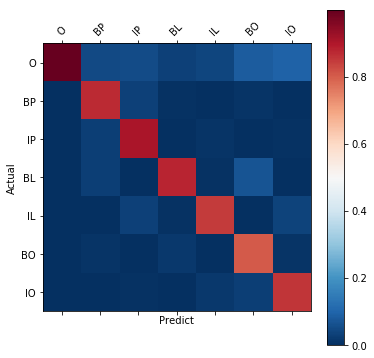

In [329]:
mapping = np.array([0,6,4,3,2,5,1])
y_true = y_cv
y_pred = y_cv_hat
y_t = np.argmax(y_true, axis=2).ravel()
y_p = np.argmax(y_pred, axis=2).ravel()
mat = pd.crosstab(y_t, y_p,rownames=['Actual'], colnames=['Predict'])
mat = mat.loc[mapping,mapping]
print(mat)
plot_confusiopdmatrix(mat)

In [327]:
save_load_utils.load_all_weights(
    model, r'model/ner_stacked_lstm_weights.h5', include_optimizer=False)

In [318]:
save_obj('model/word_tokenizer.pickle', word_tokenizer)
# save_obj('model/index_pos.pickle', index_pos)
save_load_utils.save_all_weights(model, 'model/ner_stacked_lstm_weights.h5')

In [324]:
index_pos = {v:k for k,v in pos_tokenizer.word_index.items()}
index_pos

{1: 'O',
 2: 'I-ORG',
 3: 'I-LOC',
 4: 'B-LOC',
 5: 'I-PER',
 6: 'B-ORG',
 7: 'B-PER'}

In [325]:
to_test = '大家好，我系渣渣辉，我系古天乐。'
to_test = '国信证券股份有限公司（以下简称“国信证券”）作为北京网酒网电子商务股份有限公司（以下简称”公司”或“网酒网”）的持续督导主办券商。'
to_test = '近日，位于江苏的江苏精研股份有限公司（以下简称“公司”）收到全资子公司精研（东莞）科技发展有限公司（以下简称“东莞精研”）通知，东莞精研变更了其经营范围，履行了工商变更登记手续，并取得了东莞市工商行政管理局换发的《营业执照》。'
ner_ret = test_sentences(to_test)
pretty_ner(to_test, ner_ret)

近 O
日 O
， O
位 O
于 O
江 B-ORG
苏 I-ORG
的 O
江 B-ORG
苏 I-ORG
精 I-ORG
研 I-ORG
股 I-ORG
份 I-ORG
有 I-ORG
限 I-ORG
公 I-ORG
司 I-ORG
（ O
以 O
下 O
简 O
称 O
“ O
公 B-ORG
司 I-ORG
” O
） O
收 O
到 O
全 B-ORG
资 I-ORG
子 I-ORG
公 I-ORG
司 I-ORG
精 O
研 O
（ O
东 B-ORG
莞 I-ORG
） I-ORG
科 I-ORG
技 I-ORG
发 I-ORG
展 I-ORG
有 I-ORG
限 I-ORG
公 I-ORG
司 I-ORG
（ O
以 O
下 O
简 O
称 O
“ O
东 B-LOC
莞 I-LOC
精 O
研 O
” O
） O
通 O
知 O
， O
东 B-LOC
莞 I-LOC
精 O
研 O
变 O
更 O
了 O
其 O
经 O
营 O
范 O
围 O
， O
履 O
行 O
了 O
工 O
商 O
变 O
更 O
登 O
记 O
手 O
续 O
， O
并 O
取 O
得 O
了 O
东 B-ORG
莞 I-ORG
市 I-ORG
工 I-ORG
商 I-ORG
行 I-ORG
政 I-ORG
管 I-ORG
理 I-ORG
局 I-ORG
换 O
发 O
的 O
《 O
营 O
业 O
执 O
照 O
》 O
。 O


In [ ]:
# unit test for tokenizer sentences
ss = [
    '克马尔的女儿让娜今年读五年级，她所在的班上有30多名同学，该班的“家委会”由10名家长组成。', '其实非汉非唐，又是什么与什么呢？',
    '当前国有大中型企业改制中存在的问题。'
]
vec = word_tokenizer.texts_to_sequences(ss)
assert((x_train[5, -len(vec[0]):] == np.asarray(vec[0])).all())
assert((x_cv[5, -len(vec[1]):] == np.asarray(vec[1])).all())
assert((x_test[5, -len(vec[2]):] == np.asarray(vec[2])).all())